## Attention Is All You Need

This notebook is used to train and test an attention model for stock price predictions.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from typing import Tuple, List
from tqdm import tqdm

from stock_data_processing import clean_stock_data

### Preprocessing

In [2]:
df = pd.read_csv('stock_yfinance_data.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [3]:
ticker = 'AAPL'
df = clean_stock_data(df, ticker)
df.head()

,date,open,high,low,close,adj_close,volume
0,2021-09-30,143.660004,144.380005,141.279999,141.500000,140.478485,89056700
1,2021-10-01,141.899994,142.919998,139.110001,142.649994,141.620163,94639600
2,2021-10-04,141.759995,142.210007,138.270004,139.139999,138.135513,98322000
3,2021-10-05,139.490005,142.240005,139.360001,141.110001,140.091278,80861100
4,2021-10-06,139.470001,142.149994,138.369995,142.000000,140.974869,83221100


### Define model

In [4]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_position: int, d_model: int):
        super().__init__()
        self.d_model = d_model
        position = np.arange(max_position)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pos_encoding = np.zeros((max_position, d_model))
        pos_encoding[:, 0::2] = np.sin(position * div_term)
        pos_encoding[:, 1::2] = np.cos(position * div_term)
        self.pos_encoding = tf.cast(pos_encoding[np.newaxis, ...], dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model: int, num_heads: int, dropout_rate: float = 0.1):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
            dropout=dropout_rate
        )
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(d_model * 4, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training=True):
        attn_output = self.mha(x, x, x, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class StockPricePredictor(tf.keras.Model):
    def __init__(self, 
                 d_model: int = 128,
                 num_heads: int = 8,
                 num_encoder_layers: int = 4,
                 dropout_rate: float = 0.1,
                 max_sequence_length: int = 60):
        super().__init__()
        
        self.d_model = d_model
        self.embedding = tf.keras.layers.Dense(d_model)
        self.pos_encoding = PositionalEncoding(max_sequence_length, d_model)
        
        self.encoder_layers = [
            EncoderLayer(d_model, num_heads, dropout_rate)
            for _ in range(num_encoder_layers)
        ]
        
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.final_layer = tf.keras.layers.Dense(1)
    
    def call(self, inputs, training=True):
        # Ensure inputs are float32
        x = tf.cast(inputs, dtype=tf.float32)
        
        # Create embedding
        x = self.embedding(x)
        x = self.pos_encoding(x)
        x = self.dropout(x, training=training)
        
        # Pass through encoder layers
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x, training=training)
        
        # Get the last time step
        x = x[:, -1, :]
        
        # Final prediction
        return self.final_layer(x)

def prepare_data(data: pd.DataFrame, 
                sequence_length: int,
                train_split: float = 0.8) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, MinMaxScaler]:
    """
    Prepare data for training and testing.
    """
    # Ensure data is float32
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[['close']].values).astype(np.float32)
    
    sequences = []
    targets = []
    
    for i in range(len(scaled_data) - sequence_length):
        sequences.append(scaled_data[i:(i + sequence_length)])
        targets.append(scaled_data[i + sequence_length])
    
    sequences = np.array(sequences, dtype=np.float32)
    targets = np.array(targets, dtype=np.float32)
    
    train_size = int(len(sequences) * train_split)
    
    train_sequences = sequences[:train_size]
    train_targets = targets[:train_size]
    test_sequences = sequences[train_size:]
    test_targets = targets[train_size:]
    
    return train_sequences, train_targets, test_sequences, test_targets, scaler

def train_model(model: tf.keras.Model,
                train_sequences: np.ndarray,
                train_targets: np.ndarray,
                validation_data: Tuple[np.ndarray, np.ndarray],
                batch_size: int = 32,
                epochs: int = 50,
                learning_rate: float = 0.001) -> tf.keras.callbacks.History:
    """
    Train the model with early stopping, learning rate reduction, and progress tracking.
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    # Custom progress bar callback
    class ProgressCallback(tf.keras.callbacks.Callback):
        def __init__(self, epochs):
            super().__init__()
            self.progress_bar = None
            self.epochs = epochs
            
        def on_train_begin(self, logs=None):
            self.progress_bar = tqdm(total=self.epochs, desc='Training Progress')
            
        def on_epoch_end(self, epoch, logs=None):
            self.progress_bar.update(1)
            self.progress_bar.set_postfix({
                'loss': f"{logs['loss']:.4f}",
                'val_loss': f"{logs['val_loss']:.4f}",
                'mae': f"{logs['mae']:.4f}",
                'val_mae': f"{logs['val_mae']:.4f}"
            })
            
        def on_train_end(self, logs=None):
            self.progress_bar.close()
    
    callbacks = [
        ProgressCallback(epochs),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
    ]
    
    # Use custom progress bar instead of verbose output
    history = model.fit(
        train_sequences,
        train_targets,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=validation_data,
        callbacks=callbacks,
        verbose=0  # Disable default progress bar
    )
    
    return history

#### Train model

In [5]:
# Prepare data
sequence_length = 30
train_sequences, train_targets, test_sequences, test_targets, scaler = prepare_data(
    df, sequence_length=sequence_length
)

# Create and train model
model = StockPricePredictor(
    d_model=128,
    num_heads=8,
    num_encoder_layers=3,
    dropout_rate=0.2,
    max_sequence_length=sequence_length
)

history = train_model(
    model,
    train_sequences,
    train_targets,
    validation_data=(test_sequences, test_targets),
    batch_size=32,
    epochs=100,
    learning_rate=0.0005
)

Training Progress:  70%|███████   | 70/100 [04:47<02:03,  4.11s/it, loss=0.0436, val_loss=0.0116, mae=0.1671, val_mae=0.0965]


#### Test model

In [6]:
def generate_future_sequences(last_sequence: np.ndarray, 
                            num_predictions: int,
                            num_simulations: int = 10) -> np.ndarray:
    """
    Generate multiple sequences for future predictions starting from the last known sequence.
    """
    sequences = np.tile(last_sequence, (num_simulations, 1, 1))
    predictions = np.zeros((num_simulations, num_predictions))
    
    return sequences, predictions

def forecast_future(model: StockPricePredictor,
                   last_sequence: np.ndarray,
                   num_predictions: int,
                   num_simulations: int = 10,
                   noise_level: float = 0.001) -> np.ndarray:
    """
    Generate multiple future price trajectories using the trained model.
    """
    sequences, predictions = generate_future_sequences(last_sequence, num_predictions, num_simulations)
    
    for step in range(num_predictions):
        # Generate predictions for all simulations
        step_predictions = model(sequences).numpy()
        
        # Add random noise to create different trajectories
        noise = np.random.normal(0, noise_level, size=(num_simulations, 1))
        step_predictions += noise
        
        # Store predictions
        predictions[:, step] = step_predictions.flatten()
        
        # Update sequences for next prediction
        if step < num_predictions - 1:
            sequences = np.roll(sequences, -1, axis=1)
            sequences[:, -1, 0] = step_predictions.flatten()
    
    return predictions

def plot_predictions(train_data: np.ndarray,
                    test_data: np.ndarray,
                    future_predictions: np.ndarray,
                    scaler: MinMaxScaler) -> None:
    """
    Plot historical data and future predictions, aligned at the end of training data.
    """
    plt.figure(figsize=(15, 8))
    
    # Calculate indices
    train_indices = np.arange(len(train_data))
    
    # Inverse transform the scaled data
    train_prices = scaler.inverse_transform(train_data.reshape(-1, 1)).flatten()
    test_prices = scaler.inverse_transform(test_data.reshape(-1, 1)).flatten()

    print(len(train_prices))
    
    # Plot training data
    plt.plot(train_indices, train_prices, label='Training Data', color='black')
    
    # Calculate test indices starting from end of training data
    test_indices = np.arange(len(train_data), len(train_data) + len(test_data))
    
    # Plot test data
    plt.plot(test_indices, test_prices, label='Test Data', color='blue')
    
    # Plot future predictions starting from end of training data
    future_indices = np.arange(len(train_data), 
                              len(train_data) + future_predictions.shape[1])
    
    # Inverse transform and plot each simulation
    for i in range(future_predictions.shape[0]):
        future_prices = scaler.inverse_transform(
            future_predictions[i].reshape(-1, 1)
        ).flatten()
        
        if i == 0:
            plt.plot(future_indices, future_prices, 
                    color='red', alpha=0.3, 
                    label='Future Predictions')
        else:
            plt.plot(future_indices, future_prices, 
                    color='red', alpha=0.3)
    
    plt.title(f'Stock Price Forecast of {ticker} with Simulated Trajectories')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

def prepare_data(data: pd.DataFrame, 
                sequence_length: int,
                train_split: float = 0.8) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, MinMaxScaler]:
    """
    Prepare data for training and testing.
    """
    # Ensure data is float32
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[['close']].values).astype(np.float32)
    
    sequences = []
    targets = []
    
    for i in range(len(scaled_data) - sequence_length):
        sequences.append(scaled_data[i:(i + sequence_length)])
        targets.append(scaled_data[i + sequence_length])
    
    sequences = np.array(sequences, dtype=np.float32)
    targets = np.array(targets, dtype=np.float32)
    
    train_size = int(len(sequences) * train_split)
    
    train_sequences = sequences[:train_size]
    train_targets = targets[:train_size]
    test_sequences = sequences[train_size:]
    test_targets = targets[train_size:]
    
    return train_sequences, train_targets, test_sequences, test_targets, scaler

177


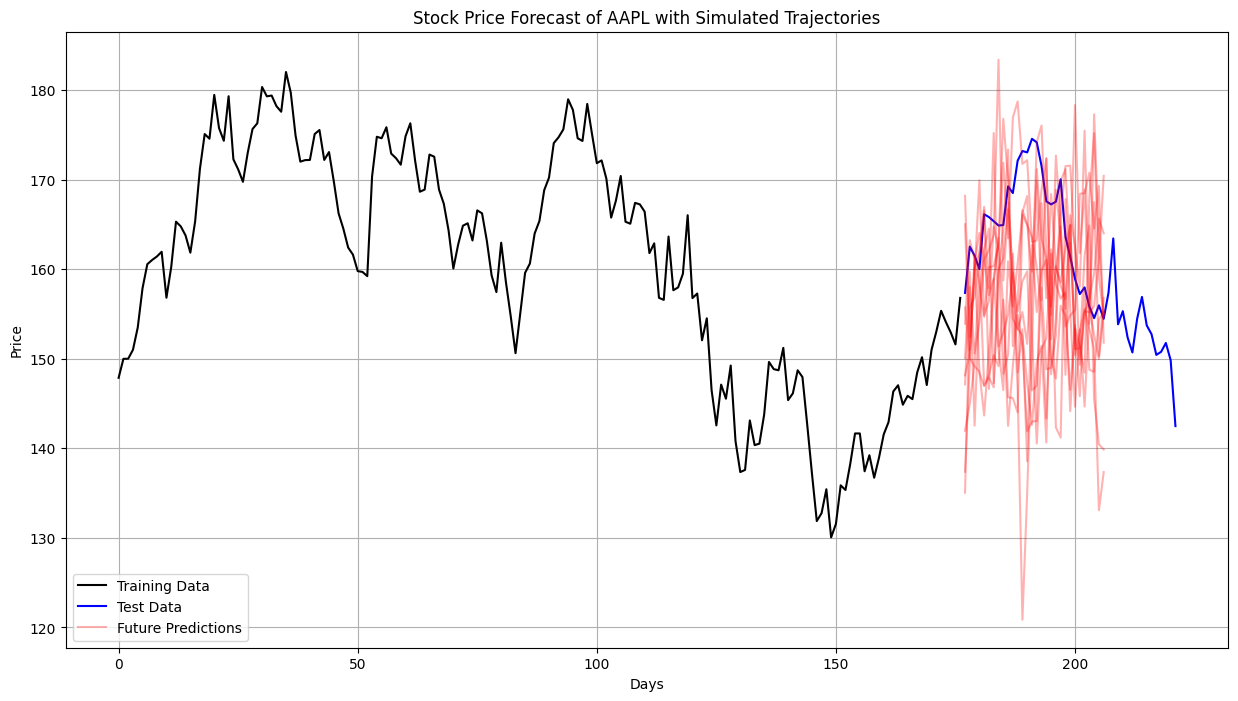

In [7]:
# After training your model
# Get the last sequence from your test data
last_sequence = test_sequences[-1:]  # Shape should be (1, sequence_length, 1)

# Generate future predictions
future_predictions = forecast_future(
    model=model,
    last_sequence=last_sequence,
    num_predictions=30,  # Number of days to predict into the future
    num_simulations=10,  # Number of different trajectories to simulate
    noise_level=0.001    # Amount of noise to add for trajectory diversity
)

# Plot the results
plot_predictions(
    train_data=train_targets,
    test_data=test_targets,
    future_predictions=future_predictions,
    scaler=scaler
)